<h1>Table of Contents<span class="tocSkip"></span></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.sparse.linalg import eigsh
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Pauli Matrices
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])
sp = np.array([[0, 1], [0, 0]])
sm = np.array([[0, 0], [1, 0]])

# Functions

In [2]:
# model Hamiltonian

# N is the number of phase points included
# Total size of the Hamiltonian is 2*N
def hamiltonian(Ec, gap, T, ng, N): # two level model applied
    # Charging energy Ec, induced gap, in our case the effective gap E(0), Transmission T, 
    # offset charge ng
    a = 4 * np.pi / N # lattice spacing
    t = 4 * Ec / a**2 # hopping

    # charging energy
    ham = 2 * t * np.eye(N) + 0j
    ham += t * np.exp(1j * 0.5 * ng * a) * np.eye(N, k = 1)
    ham += t * np.exp(-1j * 0.5 * ng * a) * np.eye(N, k = -1)
    ham += t * np.exp(-1j * 0.5 * ng * a) * np.eye(N, k = N-1) # boundary condition
    ham += t * np.exp(1j * 0.5 * ng * a) * np.eye(N, k = -N+1) # boundary condition
    ham = np.kron(ham, s0)
    
    phis = np.linspace(0, 4*np.pi, N, endpoint=False)
    ham += gap * np.kron(np.diag(np.cos(phis / 2)), sz)
    ham += gap * np.sqrt(1 - T) * np.kron(np.diag(np.sin(phis / 2)), sx)
    return ham

The implementiation of the Hamiltonian is decribed in the supplementary material section 1C: <br>
"The Hamiltonian (2) of the main text is used to the determine the qubit energy levels given the input parameters $E_C,~n_g,~\tilde{\Delta}$ and $r=\sqrt{1-T}$.
The Hamiltonian is solved numerically by discretizing the coordinate $\phi$ on a finite grid with grid spacing $\delta$, chosen to be small enough to guarantee convergence of the eigenvalues.
Following standard procedure, the derivative operator $\partial_\phi$ is implemented as a hopping operator between neighboring sites of the $\phi$-grid, with hopping strength $4 E_C / \delta^2$.
The induced charge $n_g$ enters the Hamiltonian, via the Peierls substitution, as a hopping phase e$^{i\delta n_g/2}$.
We diagonalize the Hamiltonian on the interval $\phi\,\in\,[0, 4\pi)$ with anti-periodic boundary conditions.
This choice is required to guarantee the smoothness of the wave functions and the correct offset of energy levels with respect to $n_g$."

In [20]:
# model functions
def bound_state_equation(x, phi, gamma1, gamma2, gap, xr): # Eq. 1 in the paper
    gamma = gamma1 + gamma2
    omega = ((gap**2 - x**2) * (x**2 - xr**2 - gamma**2/4) + gap**2 * gamma1 * gamma2 * np.sin(phi/2)**2)
    return omega + gamma * x**2 * np.sqrt(gap**2 - x**2)

def T_BW(gamma1, gamma2, xr): # extract transmission based on \epsilon_r and Gammas
    T = gamma1*gamma2/(xr**2+1/4*(gamma1+gamma2)**2)
    return T

def Delta_tilde(gamma1, gamma2, gap, xr): # get E(0) = \tilde(\Delta), given Gammas, Al gap and epsilon_r
    """
    Solves Eq. 1 at zero phase to find E(0) = \tilde(\Delta) for given Gammas, gap and epsilon_r
    """
    sol = brentq(lambda x: bound_state_equation(x, 0, gamma1/gap, gamma2/gap, 1, xr/gap), 0, 1-1e-3, full_output=False)*gap
    return sol

eps_sample = np.array([0,0.1,0.3,0.5,1,1.5,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,80,90,100])
# array of test epsilons

def get_freq(Ec, Delta, T): # get degenaracy qubit frequency for given Ec, gap and transmission
    ham = hamiltonian(Ec, Delta, T, ng=0.5, N=201)
    evals = np.linalg.eigvalsh(ham)
    return evals[3]-evals[0]

def get_disp(Ec, Delta, T): # get dispersion amplitude for given Ec, gap and transmission
    ham = hamiltonian(Ec, Delta, T, ng=0, N=201)
    evals = np.linalg.eigvalsh(ham)
    return (evals[3]-evals[0]-get_freq(Ec, Delta, T))

def get_freqs_vs_disps(Ec, Gamma, xrs, gap = 45): # Model degenaracy frequency vs dispersion amplitude, Al gap of 45 GHz = 190 µeV 
    """
    Get corresponding qubit frequency and dispersion amplitude given Ec, Gamma and range of epsilon_r.
    From Epsilon_r and Gamma the Breit-Wigner transmission and effective gap E(0)=tilde{Delta} are calculated.
    By feeding these into get_freq and get_disp functions, corresponding frequencies and dispersion amplitudes
    are calculated.
    """
    disp = []
    freq = []
    for xr in xrs:
        T = T_BW(Gamma, Gamma, xr) # get transmission for given epsilon_r and Gamma
        Delta = Delta_tilde(Gamma, Gamma, gap, xr) # get effective gap E(0)
        freq.append(get_freq(Ec, Delta, T))
        disp.append(get_disp(Ec, Delta, T))
    return np.array(freq), np.array(disp)

def get_freq02(Ec, Delta, T): # get 0->2 degenaracy frequency for given Ec, gap and transmission
    ham = hamiltonian(Ec, Delta, T, ng=0.5, N=201)
    evals = np.linalg.eigvalsh(ham)
    return evals[4]-evals[0]

def get_disp02(Ec, Delta, T): # get 0->2 dispersion amplitude for given Ec, gap and transmission
    ham = hamiltonian(Ec, Delta, T, ng=0, N=201)
    evals = np.linalg.eigvalsh(ham)
    f = get_freq02(Ec, Delta, T)    
    return (f-(evals[4]-evals[0]))


def get_freqs02_vs_disps02(Ec, Gamma, xrs, gap = 45): # Model 0->2 degenaracy frequency vs 0->2 dispersion amplitude, Al gap of 45 GHz = 190 µeV 
    """
    Get corresponding 0->2 frequency and 0->2 dispersion amplitude given Ec, Gamma and range of epsilon_r.
    From Epsilon_r and Gamma the Breit-Wigner transmission and effective gap E(0)=tilde{Delta} are calculated.
    By feeding these into get_freq and get_disp functions, corresponding frequencies and dispersion amplitudes
    are calculated.
    """
    disp = []
    freq = []
    for xr in xrs:
        T = T_BW(Gamma, Gamma, xr)
        Delta = Delta_tilde(Gamma, Gamma, gap, xr)
        freq.append(get_freq02(Ec, Delta, T))
        disp.append(get_disp02(Ec, Delta, T))
    return np.array(freq), np.array(disp)


In [21]:
# Transmon functions
from numpy.linalg import eig

def energies(Ej, Ec, ng, N): # Solve transmon Hamiltonian basded on E_J, E_C, and charge offset n_g
    n_op = np.diag(np.arange(-N, N + 1, 1, dtype=int)) - ng * np.eye(2*N+1)
    ham = 4 * Ec * n_op@n_op
    ham += 0.5 * Ej * np.eye(2*N+1, k=1)
    ham += 0.5 * Ej * np.eye(2*N+1, k=-1)
    evals = np.linalg.eigvalsh(ham)
    evals -= evals.min()
    return evals

def find_dispersion(Ec, Ej): # transmon dispersion amplitude 
    N = 50
    e = energies(Ej, Ec, 0, N)
    disp = (e[1] - e[0]-find_freq(Ec, Ej)) 
    return disp

def find_dispersion02(Ec, Ej): # transmon 0->2 dispersion amplitude 
    N = 50
    e = energies(Ej, Ec, 0, N)
    disp = (find_freq02(Ec, Ej) - (e[2] - e[0]))
    return disp

def find_freq(Ec, Ej): # transmon degenaracy frequency, note n_g axis in units of 2e as opposed to 1e above
    N = 50
    e = energies(Ej, Ec, 0.25, N)
    freq = (e[1] - e[0])
    return freq

def find_freq02(Ec, Ej): # transmon 0->2 degenaracy frequency
    N = 50
    e = energies(Ej, Ec, 0.25, N)
    freq02 = (e[2] - e[0])
    return freq02

# Load data

In [22]:
# create transmon theory data
params = np.loadtxt('fitparameters.txt', comments='#') # load fit parameters
Ej = np.linspace(0,90,201)
Ec1 = params[0]

#transmon model
f_transmon = np.zeros(len(Ej))
d_transmon = np.zeros(len(Ej))
for (i,es) in enumerate(Ej):
    d_transmon[i] = find_dispersion(Ec1, es)*1000 # MHz
    f_transmon[i] = find_freq(Ec1, es) # GHz
    
# 02 transmon model    
f_transmon02 = np.zeros(len(Ej))
d_transmon02 = np.zeros(len(Ej))
alpha_koch = []
for (i,es) in enumerate(Ej):
    d_transmon02[i] = find_dispersion02(Ec1, es)*1000 # MHz
    f_transmon02[i] = find_freq02(Ec1, es) # GHz

## Load 01 data from Res. 1 and Res. 2

In [23]:
f_model = [] # model data
d_model = [] # model data
cutter = [] # experimental data
f_expt = [] # experimental data
d_expt = [] # experimental data
for i in range(2):
    c, f1, d1 = np.loadtxt('Res'+str(i+1)+'_01.txt', comments='#', unpack=True ) # V_Q (V), f_{01} (GHz), \delta_{01} (MHz)

    res = [params[0], params[i+1:i+2]]
    f, d = get_freqs_vs_disps(*res, eps_sample)
    f_model.append(f) # GHz
    d_model.append(d*1e3) # MHz
    f_expt.append(f1) # list with qubit frequencies (GHz) for both resonances
    d_expt.append(d1) # list with dispersion amplitudes (MHz) for both resonances
    cutter.append(c) # list with corresponding V_Q (V) for both resonances

## Load 02 data from Res. 2

In [24]:
f01_expt, d01_expt, f02_expt, d02_expt = np.loadtxt('Res2_02.txt', comments='#', unpack=True) # Res. 2 f_01 (GHz), \delta_{01} (MHz), f_02 (GHz), \delta_{02} (MHz)
f02_model, d02_model = get_freqs02_vs_disps02(*res, eps_sample) # model 0->2 frequency and dispersion, GHz
d02_model *= 1e3 # convert to MHz

# Fig. 4

(2.2, 5.1)

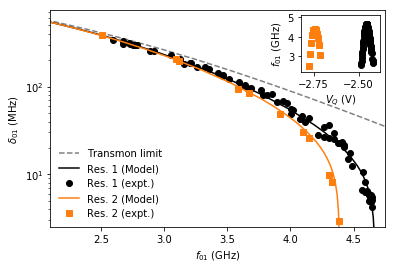

In [33]:
#Fig 4
m = ['o', 's'] # markers
c = ['k', 'C1'] # colors
l = ['Res. 1 (expt.)', 'Res. 2 (expt.)'] # data legend
l_m = ['Res. 1 (Model)', 'Res. 2 (Model)' ] # model legend
plt.plot(f_transmon, d_transmon,'--', color = 'Grey', label = 'Transmon limit') # Transmon solution
for i in range(2):
    plt.plot(f_model[i], d_model[i], '-', color = c[i], label = l_m[i]) # Model
    plt.plot(f_expt[i], d_expt[i], m[i], color = c[i], label = l[i]) # data

# formatting
plt.yscale("log")
plt.xlim([2.1, 4.75])
plt.ylim([2.5, 750])
plt.xlabel("$f_{01}$ (GHz)")
plt.ylabel("$\delta_{01}$ (MHz)")
plt.legend(frameon = False, loc = 3)

# inset
inset_axes(plt.gca(), width=1.1, height=0.8)
for i in range(2):
    plt.plot(cutter[i], f_expt[i], m[i], color = c[i], label = l[i])
   
plt.xlabel("$V_Q$ (V)")
plt.ylabel("$f_{01}$ (GHz)")
plt.xlim(-2.82, -2.38)
plt.ylim(2.2, 5.1)


# Fig. 5

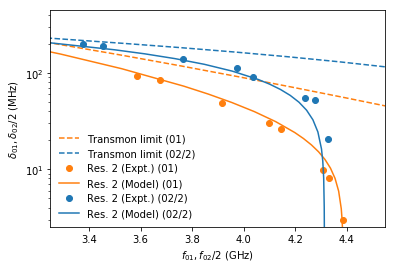

In [9]:
# Fig 5

# Transmon solutions
plt.plot(f_transmon, d_transmon,'--', color = 'C1', label = 'Transmon limit (01)')
plt.plot(f_transmon02/2, d_transmon02/2,'--', color = 'C0', label = 'Transmon limit (02/2)')

# Experimental data and resonant model solutions
plt.plot(f01_expt, d01_expt, 'o', color = 'C1', label = 'Res. 2 (Expt.) (01)')
plt.plot(f_model[1], d_model[1], '-',  color = 'C1', label = 'Res. 2 (Model) (01)')
plt.plot(f02_expt/2, d02_expt/2, 'o', color = 'C0', label = 'Res. 2 (Expt.) (02/2)') # divide by two as it is two-photon transition
plt.plot(f02_model/2, d02_model/2, '-',  color = 'C0', label = 'Res. 2 (Model) (02/2)') # divide by two as it is two-photon transition

# Formatting
plt.yscale("log")
plt.ylim([2.5, 450])
plt.xlim([3.25, 4.55])
plt.xlabel("$f_{01}, f_{02}/2$ (GHz)")
plt.ylabel("$\delta_{01}, \delta_{02}/2$ (MHz)")
plt.legend(frameon = False)

